In [1]:
%matplotlib inline

import numpy as np
from scipy.stats import beta, skewnorm, uniform, expon, lognorm, weibull_min, chi2, t, gumbel_r, wasserstein_distance, moment
from scipy.special import gamma
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
from scipy.stats import ks_2samp

### Distributions of the independent components

In [2]:
rvs = [beta(2,3), expon(scale=0.1), skewnorm(a=6), gumbel_r, lognorm(s=1), weibull_min(c=2), chi2(df=6)]

In [3]:
def sample_normed(n, rv):
    return (rv.rvs(size=n) - rv.mean()) / rv.std()

In [4]:
n = 5000
eps = np.zeros((n,len(rvs)))
for i, rv in enumerate(rvs):
    eps[:,i] = sample_normed(n,rv)

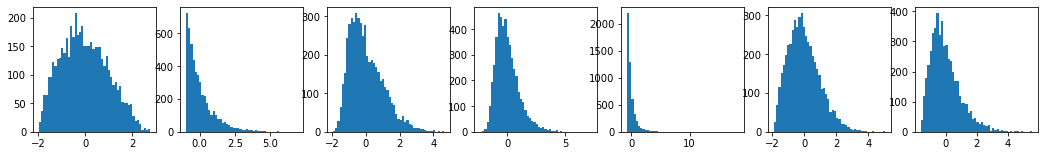

In [5]:
fig, ax = plt.subplots(1, 7, figsize=(18,2.3))

for j in range(7):
        ax[j].hist(eps[:,j], bins=50)

plt.show()

### Create synthetic observations

In [6]:
joint_latents = [0,1,2,3]
env1_specific = [4]
env2_specific = [5]
env3_specific = [6]
d1 = 13
d2 = 14
d3 = 15
n1 = 3000
n2 = 3000
n3 = 3000

env1_latents = joint_latents + env1_specific
env2_latents = joint_latents + env2_specific
env3_latents = joint_latents + env3_specific

In [7]:
def matrix_from_normal(shape, mu=0, sigma=1):
    A = np.random.normal(loc=mu, scale=sigma, size=shape)
    return A

In [8]:
# Sample entries of G1
#np.random.seed(101)
G1 = matrix_from_normal(shape=(d1,len(env1_latents)))
G1.round(2)

array([[ 0.21, -0.67, -1.19,  0.04, -1.17],
       [-0.96,  1.05,  0.86, -1.52, -0.81],
       [-0.68,  0.72,  1.22,  1.44, -0.03],
       [ 1.18, -1.89,  1.43,  0.96, -0.52],
       [-0.23, -1.05,  0.69, -0.51,  0.58],
       [ 0.52,  0.85,  0.12,  1.48, -1.36],
       [ 0.7 , -0.71, -0.8 , -1.04, -0.44],
       [ 0.53,  0.35, -0.9 ,  0.92, -0.57],
       [-1.46, -0.96, -1.26, -0.66,  0.6 ],
       [ 0.88, -1.75, -0.15,  2.28, -0.1 ],
       [-0.35, -1.47, -2.11, -0.16,  1.34],
       [ 0.69,  0.86,  0.07,  2.12, -1.44],
       [ 0.54,  0.74,  0.67, -0.3 , -1.27]])

In [9]:
# G2 and G3
#np.random.seed(102)
G2 = matrix_from_normal(shape=(d2,len(env2_latents)))

#np.random.seed(103)
G3 = matrix_from_normal(shape=(d3,len(env3_latents)))

In [10]:
def sample(n, mixing, rvs):
    nr_comps = len(rvs)
    eps = np.zeros((n,nr_comps))
    for i, rv in enumerate(rvs):
        eps[:,i] = sample_normed(n,rv)
    X = np.matmul(mixing, np.transpose(eps))
    return(X)

In [11]:
# Create synthetic data (uncoupled!!)
X1 = sample(n1, G1, [rvs[i] for i in env1_latents])
X2 = sample(n2, G2, [rvs[i] for i in env2_latents])
X3 = sample(n3, G3, [rvs[i] for i in env3_latents])

### Apply linear ICA to recover the (empirical) distribution of the sources

In [12]:
def rescale_columns(X):
    for i in range(X.shape[1]):
        X[:,i] = (X[:,i] - X[:,i].mean()) / X[:,i].std()
    return X

# X1 has shape p x n
def get_sources(X, seed=101):
    cov = np.cov(X)
    rk = np.linalg.matrix_rank(cov)
    print("Rank:", rk)
    
    ICA = FastICA(n_components=rk, random_state=seed, whiten='unit-variance', max_iter=1000) 
    ICA.fit(np.transpose(X))
    print("Iterations:", ICA.n_iter_)
    eps = ICA.transform(np.transpose(X))
    scaling = eps.std(axis=0)
    
    eps = rescale_columns(eps)
    mixing = np.matmul(ICA.mixing_, np.diag(scaling))    
    
    return eps, mixing

In [13]:
eps1, mixing1 = get_sources(X1)

Rank: 5
Iterations: 6


In [14]:
mixing1

array([[ 0.02424219,  1.21240613,  0.27219649, -0.66580535, -1.18022812],
       [-1.43366683,  0.87665963, -1.01773665,  1.04466527,  0.86801283],
       [ 1.47348553,  0.01164363, -0.71916295,  0.72512546,  1.23356446],
       [ 0.82486257,  0.59456667,  1.16800929, -1.78592598,  1.47577206],
       [-0.52901581, -0.54075648, -0.24667667, -1.00872285,  0.67737127],
       [ 1.47481217,  1.3466503 ,  0.52443826,  0.84396972,  0.16803095],
       [-1.08521426,  0.4800788 ,  0.73770017, -0.70118997, -0.79715276],
       [ 0.90432137,  0.5360821 ,  0.57341661,  0.32580229, -0.88193206],
       [-0.60612143, -0.5798935 , -1.40622446, -0.9773154 , -1.31854239],
       [ 2.1682814 ,  0.09865838,  0.93464673, -1.69811527, -0.137777  ],
       [-0.17822199, -1.38090964, -0.26088185, -1.49368278, -2.17849578],
       [ 2.09836792,  1.41505909,  0.70830012,  0.8537747 ,  0.12601009],
       [-0.29788413,  1.30851769,  0.51173691,  0.75092935,  0.71272202]])

In [15]:
eps2, mixing2 = get_sources(X2, seed=102)

Rank: 5
Iterations: 6


In [16]:
eps3, mixing3 = get_sources(X3, seed=103)

Rank: 5
Iterations: 11


In [17]:
# Collect results
indep_comps = [eps1, eps2, eps3]
mixings = [mixing1, mixing2, mixing3]

### Plot recovered distributions

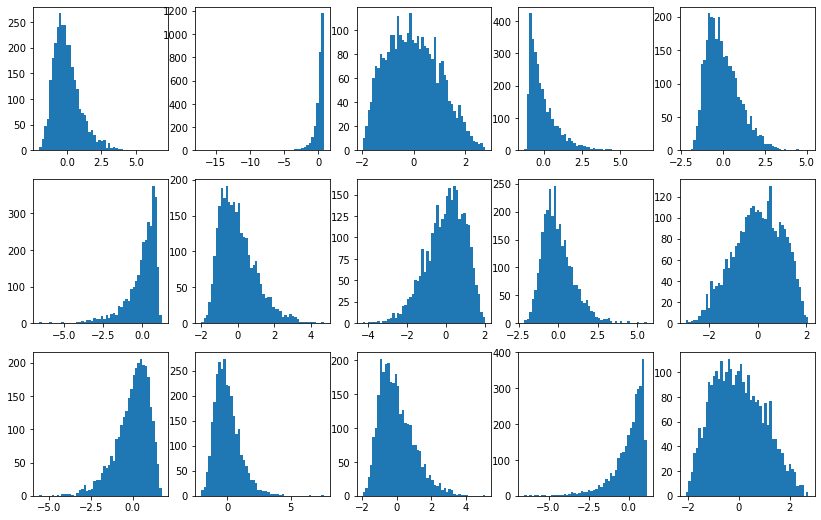

In [18]:
fig, ax = plt.subplots(3, 5, figsize=(14, 9))

for i in range(3):
    for j in range(5):
        ax[i,j].hist(indep_comps[i][:,j], bins=50)

plt.show()

In [36]:
ks_2samp(eps1[:,3], -eps2[:,0]).pvalue

0.4056324720236581

### Matching

In [21]:
def third_moments_distance(X,Y):
    M_X = moment(X, moment=3) # central moment
    M_Y = moment(Y, moment=3)
    dist = abs(M_X - M_Y)
    return dist

In [22]:
# 1-Wasserstein metric between empirical distributions

def wasserstein_dist(X1,X2):
    p1 = X1.shape[1]
    p2 = X2.shape[1]
    D = np.zeros((p1,p2))
    for i in range(p1):
        for j in range(p2):
            D[i,j] = wasserstein_distance(X1[:,i],X2[:,j]) 
    return D


def wasserstein_dist_signed(X1,X2):
    p1 = X1.shape[1]
    p2 = X2.shape[1]
    D_large = np.zeros((p1,2*p2))
    X2_large = np.concatenate((X2,-X2),axis=1)
    for i in range(p1):
        for j in range(2*p2):
            D_large[i,j] = wasserstein_distance(X1[:,i],X2_large[:,j]) 
    D = np.zeros((p1,p2))
    for i in range(p2):
        D[:,i] = D_large[:,[i,i+p2]].min(axis=1)
    return D

In [44]:
def signed_pvalues_matrix(X1,X2):
    p1 = X1.shape[1]
    p2 = X2.shape[1]
    pvals_large = np.zeros((p1,2*p2))
    X2_large = np.concatenate((X2,-X2),axis=1)
    for i in range(p1):
        for j in range(2*p2):
            pvals_large[i,j] = ks_2samp(X1[:,i],X2_large[:,j]).pvalue
    pvals = np.zeros((p1,p2))
    for i in range(p2):
        pvals[:,i] = pvals_large[:,[i,i+p2]].max(axis=1)
    return pvals

In [45]:
def minimum_matching(D, A=10):
    p1, p2 = D.shape
    threshold = A * D.min()
    matching = {}
    for i in range(p1):
        row_argmin = D[i,:].argmin()
        row_min = D[i,:].min()
        if (D[:,row_argmin].argmin() == i) and (row_min < threshold):
            matching[i] = row_argmin
    return matching

In [53]:
def maximum_matching(pvals, level=0.05):
    p1, p2 = pvals.shape
    matching = {}
    for i in range(p1):
        row_argmax = pvals[i,:].argmax()
        row_max = pvals[i,:].max()
        if (pvals[:,row_argmax].argmax() == i) and (row_max >= level):
            matching[i] = row_argmax
    return matching

In [54]:
P12 = signed_pvalues_matrix(eps1,eps2).round(3)
P12.round(3)

array([[0.   , 0.119, 0.   , 0.629, 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.054, 0.   , 0.695],
       [0.406, 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.872, 0.127, 0.062, 0.   ]])

In [55]:
maximum_matching(P12)

{0: 3, 2: 4, 3: 0, 4: 1}

In [56]:
D12 = wasserstein_dist_signed(eps1,eps2)
D12.round(3)

array([[0.134, 0.043, 0.097, 0.024, 0.155],
       [0.228, 0.357, 0.413, 0.338, 0.468],
       [0.289, 0.138, 0.066, 0.145, 0.02 ],
       [0.02 , 0.154, 0.228, 0.152, 0.286],
       [0.173, 0.023, 0.059, 0.049, 0.115]])

In [57]:
minimum_matching(D12)

{0: 3, 2: 4, 3: 0, 4: 1}

In [26]:
D13 = wasserstein_dist_signed(eps1,eps3)
D13.round(3)

array([[0.031, 0.027, 0.05 , 0.131, 0.155],
       [0.342, 0.337, 0.367, 0.235, 0.468],
       [0.149, 0.143, 0.125, 0.286, 0.02 ],
       [0.145, 0.153, 0.166, 0.016, 0.282],
       [0.036, 0.052, 0.018, 0.169, 0.11 ]])

In [27]:
minimum_matching(D13)

{0: 1, 2: 4, 3: 3, 4: 2}

In [28]:
D23 = wasserstein_dist_signed(eps2,eps3)
D23.round(3)

array([[0.145, 0.152, 0.166, 0.019, 0.282],
       [0.02 , 0.044, 0.016, 0.151, 0.129],
       [0.085, 0.079, 0.063, 0.224, 0.059],
       [0.028, 0.018, 0.041, 0.148, 0.138],
       [0.143, 0.137, 0.121, 0.282, 0.025]])

In [548]:
minimum_matching(D23)

{0: 1, 1: 0, 2: 3, 4: 4}

In [549]:
# Definition of a joint factor:
# A collection of distributions of size |E| such that 
# - all distibutions within that joint factor match

In [550]:
def is_consistent(f, matchings):
    for i in range(len(f)):
        for j in range(i+1, len(f)):
            if f[i] not in list(matchings[str(i)+str(j)].keys()):
                return False
            if matchings[str(i)+str(j)][f[i]] != f[j]:
                return False
    return True



def get_joint_factors(indep_comps):
    
    nr_env = len(indep_comps)
    
    matchings = {}
    for i in range(nr_env):
        for j in range(i+1, nr_env):
            D = wasserstein_dist_signed(indep_comps[i],indep_comps[j])
            matchings[str(i)+str(j)] = minimum_matching(D)
    
    # Define potential factors
    pot_factors = [[i] for i in list(matchings['01'].keys())] 
    for f in pot_factors:
        for i in range(1,nr_env):
            if f[0] not in list(matchings['0'+str(i)].keys()):
                continue
            else:
                f.append(matchings['0'+str(i)][f[0]])
    pot_factors = [f for f in pot_factors if len(f)==nr_env]
    
    # Only keep consistent factors
    factors = [f for f in pot_factors if is_consistent(f, matchings)]
    
    return(factors)

In [551]:
joint_factors = get_joint_factors(indep_comps)
joint_factors

# Interpretation:
# We match the following recovered components:
# component 0 of domain 1 WITH component 0 of domain 2 WITH component 2 of domain 3

[[0, 4, 4], [1, 2, 3], [2, 0, 1], [4, 1, 0]]

### Recover joint mixing matrix

In [552]:
def matching_sign(distr1, distr2):
        normal_dist = wasserstein_distance(distr1,distr2) 
        flipped_dist = wasserstein_distance(distr1,-distr2)
        if normal_dist <= flipped_dist:
            return 1
        else:
            return -1 

In [553]:
def add_signs_to_factor(f, indep_comps):
    
    signs = [1]
    
    for i in range(1,len(f)):
        signs.append(matching_sign(indep_comps[0][:,f[0]], indep_comps[i][:,f[i]]))
         
    return signs

In [554]:
joint_factor_signs = [add_signs_to_factor(f, indep_comps) for f in joint_factors]
joint_factor_signs

[[1, -1, -1], [1, -1, 1], [1, -1, 1], [1, -1, -1]]

In [555]:
def joint_mixing_matrix(mixings, joint_factors, joint_factor_signs):
    
    nr_env = len(mixings)
    nr_joint = len(joint_factors)
    total_nr_obs = sum([M.shape[0] for M in mixings])
    total_nr_lat = sum([M.shape[1]-nr_joint for M in mixings]) + nr_joint
    M_large = np.zeros((total_nr_obs, total_nr_lat))
    
    # Joint columns
    for i,f in enumerate(joint_factors):
        current_row = 0
        for env in range(nr_env):
            col = joint_factor_signs[i][env] * mixings[env][:,f[env]]
            M_large[np.ix_(np.arange(current_row,(current_row+len(col))),np.array([i]))] \
            = col.reshape((len(col),1))
            current_row = current_row + len(col)
    
    # Domain-specific columns
    current_col = len(joint_factors)
    current_row = 0
    for env in range(nr_env):
        M = mixings[env]
        nrows, ncols = M.shape
        joint_cols = [f[env] for f in joint_factors]
        domain_spec_cols = set(np.arange(ncols)) - set(joint_cols)
        for i, col in enumerate(domain_spec_cols):
            M_large[np.ix_(np.arange(current_row,(current_row+nrows)),np.array([current_col+i]))] \
            = M[:,col].reshape((nrows,1))
        current_col = current_col + len(domain_spec_cols)
        current_row = current_row + nrows
    return(M_large)

In [556]:
B = joint_mixing_matrix(mixings, joint_factors, joint_factor_signs).round(2)
B

array([[-0.36,  0.5 , -0.07, -0.16, -0.94,  0.  ,  0.  ],
       [-0.41,  0.85, -0.54, -0.87, -0.33,  0.  ,  0.  ],
       [ 0.05,  0.76,  0.61,  0.04,  0.5 ,  0.  ,  0.  ],
       [-1.4 ,  0.38, -1.92, -2.15, -0.86,  0.  ,  0.  ],
       [ 0.7 , -0.17,  0.02,  2.47, -0.91,  0.  ,  0.  ],
       [-0.43,  1.4 , -1.88,  1.47, -0.08,  0.  ,  0.  ],
       [ 0.2 , -1.08,  0.72,  0.32,  0.42,  0.  ,  0.  ],
       [-0.07,  1.67, -2.34,  0.59,  0.94,  0.  ,  0.  ],
       [-0.14,  2.05, -0.77,  2.12,  0.46,  0.  ,  0.  ],
       [ 0.08, -1.22, -1.08,  1.48, -1.9 ,  0.  ,  0.  ],
       [ 0.84,  1.01, -0.24,  1.09, -0.71,  0.  ,  0.  ],
       [-0.06, -0.95,  0.51,  0.55, -0.61,  0.  ,  0.  ],
       [ 0.82,  0.29, -1.05,  0.07, -1.09,  0.  ,  0.  ],
       [-1.7 ,  0.57,  0.9 , -1.38,  0.  , -1.52,  0.  ],
       [ 2.13,  0.3 ,  0.77,  0.09,  0.  , -0.35,  0.  ],
       [ 1.08,  0.32,  0.28, -1.23,  0.  ,  0.05,  0.  ],
       [ 0.24,  0.09,  1.17,  0.03,  0.  ,  0.07,  0.  ],
       [ 0.91,

For comparison:

In [563]:
G1.round(2)

array([[-0.18, -0.07, -0.34,  0.53,  0.93],
       [-0.87, -0.53, -0.33,  0.87,  0.33],
       [ 0.05,  0.56,  0.09,  0.79, -0.45],
       [-2.18, -1.84, -1.31,  0.41,  0.78],
       [ 2.48,  0.07,  0.58, -0.19,  0.94],
       [ 1.47, -1.74, -0.44,  1.42,  0.15],
       [ 0.31,  0.7 ,  0.14, -1.09, -0.43],
       [ 0.64, -2.2 , -0.02,  1.65, -0.86],
       [ 2.12, -0.69, -0.14,  2.1 , -0.32],
       [ 1.46, -0.97, -0.06, -1.26,  1.82],
       [ 1.13, -0.22,  0.84,  0.98,  0.76],
       [ 0.52,  0.51, -0.14, -0.94,  0.57],
       [ 0.13, -1.  ,  0.82,  0.22,  1.06]])

In [564]:
G2.round(2)

array([[-1.39,  0.79, -1.69,  0.49, -1.63],
       [ 0.06,  0.62,  2.16,  0.45, -0.28],
       [-1.25,  0.17,  1.  ,  0.4 ,  0.1 ],
       [ 0.  ,  1.14,  0.27,  0.12,  0.01],
       [-1.64,  0.01,  0.95, -0.48, -0.78],
       [ 1.3 , -1.97, -0.38,  1.71, -0.53],
       [ 0.37,  0.21,  0.13, -1.11,  2.55],
       [ 0.26, -1.42, -1.73, -0.32, -0.37],
       [ 1.17, -0.88, -0.55,  1.34, -1.58],
       [-0.51,  0.49,  0.21, -1.12, -1.13],
       [-0.31, -1.3 ,  0.15, -1.18, -2.11],
       [-1.64,  1.12,  1.8 , -0.26, -0.7 ],
       [ 0.7 ,  1.19,  0.87, -0.58, -1.88],
       [-0.11, -2.08, -0.38, -0.17, -0.99]])

In [565]:
G3.round(2)

array([[-0.02, -1.15,  0.25,  0.06, -1.98],
       [ 0.73, -0.84, -1.4 , -0.86, -1.05],
       [ 0.66,  0.07,  0.7 , -0.53,  2.5 ],
       [ 0.95,  0.79,  0.85,  0.74,  0.7 ],
       [ 0.34,  2.07, -0.79, -0.4 ,  0.3 ],
       [-0.52, -0.93,  1.  ,  0.49, -1.43],
       [ 1.29, -0.32,  0.42, -1.88,  0.03],
       [ 0.6 ,  0.72,  0.57, -0.59, -0.62],
       [ 0.3 ,  0.46, -1.43,  0.74,  0.05],
       [ 0.39,  1.18,  1.3 , -1.9 ,  0.17],
       [-0.63, -1.21,  0.75,  0.32,  1.6 ],
       [ 0.41, -0.94,  0.25, -1.62, -0.1 ],
       [ 0.86,  1.58, -0.82,  0.63,  0.19],
       [ 0.48, -0.08, -2.58,  1.29,  0.65],
       [-0.05,  1.05, -0.83, -1.89,  1.59]])

In [560]:
mixing1.round(2)

array([[-0.36,  0.5 , -0.07, -0.94, -0.16],
       [-0.41,  0.85, -0.54, -0.33, -0.87],
       [ 0.05,  0.76,  0.61,  0.5 ,  0.04],
       [-1.4 ,  0.38, -1.92, -0.86, -2.15],
       [ 0.7 , -0.17,  0.02, -0.91,  2.47],
       [-0.43,  1.4 , -1.88, -0.08,  1.47],
       [ 0.2 , -1.08,  0.72,  0.42,  0.32],
       [-0.07,  1.67, -2.34,  0.94,  0.59],
       [-0.14,  2.05, -0.77,  0.46,  2.12],
       [ 0.08, -1.22, -1.08, -1.9 ,  1.48],
       [ 0.84,  1.01, -0.24, -0.71,  1.09],
       [-0.06, -0.95,  0.51, -0.61,  0.55],
       [ 0.82,  0.29, -1.05, -1.09,  0.07]])

In [561]:
mixing2.round(2)

array([[-0.9 ,  1.38, -0.57, -1.52,  1.7 ],
       [-0.77, -0.09, -0.3 , -0.35, -2.13],
       [-0.28,  1.23, -0.32,  0.05, -1.08],
       [-1.17, -0.03, -0.09,  0.07, -0.24],
       [-0.18,  1.59,  0.56, -0.86, -0.91],
       [ 1.99, -1.21, -1.76, -0.62,  0.24],
       [ 0.01, -0.37,  1.11,  2.58, -0.18],
       [ 1.52, -0.22,  0.19, -0.38,  1.72],
       [ 0.82, -1.12, -1.39, -1.6 ,  0.56],
       [-0.59,  0.46,  1.14, -1.13, -0.03],
       [ 1.17,  0.29,  1.17, -2.23,  0.05],
       [-1.35,  1.57,  0.4 , -0.75, -1.74],
       [-1.36, -0.76,  0.65, -1.85, -0.6 ],
       [ 2.06,  0.14,  0.12, -1.11,  0.38]])

In [562]:
mixing3.round(2)

array([[-0.14, -1.24, -1.85,  0.11, -0.54],
       [-0.63, -0.95, -1.17, -0.78,  1.27],
       [-0.56,  0.19,  2.59, -0.58, -0.2 ],
       [-1.01,  0.89,  0.8 ,  0.64, -0.67],
       [-0.22,  2.07,  0.09, -0.5 ,  0.83],
       [ 0.3 , -0.97, -1.22,  0.51, -1.23],
       [-1.27, -0.38,  0.19, -1.95, -0.2 ],
       [-0.67,  0.69, -0.52, -0.69, -0.57],
       [-0.17,  0.47, -0.21,  0.79,  1.35],
       [-0.45,  1.14,  0.37, -2.07, -1.09],
       [ 0.64, -1.12,  1.74,  0.39, -0.53],
       [-0.39, -1.01,  0.04, -1.62, -0.14],
       [-0.77,  1.62, -0.02,  0.56,  0.84],
       [-0.22, -0.03,  0.21,  1.43,  2.53],
       [ 0.31,  1.03,  1.41, -1.92,  1.12]])

Notes: 
Could sample from "empirical joint distribution" now:
- Have empirical distribution of each independent component (merge the ones for the joint components).
- Sample from the empirical distributions.
- Using the joint mixing matrix, this produces samples of the joint distribution.

Using the joint mixing matrix we can also transport observations in one domain to another.